In [1]:
N_sample = 100 # number of samples to keep from each chain

## imports

In [2]:
import lenstronomy

lenstronomy.__version__

'1.9.3'

In [3]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc

from lenstronomy.Util import util
from lenstronomy.Util import param_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
# import lens model solver with 4 image positions constrains
from lenstronomy.LensModel.Solver.solver4point import Solver4Point

import paperfig as pf
pf.set_fontscale(2.)

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [4]:
gc.collect()

0

## functions

In [5]:
savefig = False

In [6]:
import sys
sys.path.insert(0, './process_output')

# load necessary functions for BIC computation and unpickling composite model outputs
from output_class import *

# load output files

## load power-law model chains and process

In [7]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run145_0_0_1_0_0_shortened',
    '2038_run145_0_0_2_0_0_shortened',
    '2038_run145_0_1_0_0_0_shortened',
    '2038_run145_0_1_1_0_0_shortened',
    '2038_run145_0_1_2_0_0_shortened',
    
    '2038_run146_0_0_0_0_0_shortened',
    '2038_run146_0_0_1_0_0_shortened',
    '2038_run146_0_0_2_0_0_shortened',
    '2038_run146_0_1_0_0_0_shortened',
    '2038_run146_0_1_1_0_0_shortened',
    '2038_run146_0_1_2_0_0_shortened',
]

In [8]:
powerlaw_bics = []
powerlaw_param_arrays = []
powerlaw_num_param_arrays = []
powerlaw_kwargs_models = []
powerlaw_kwargs_constraints = []
powerlaw_param_classes = []
powerlaw_lens_models = []
powerlaw_kwargs_likelihoods = []
powerlaw_multi_band_list = []

for job_name_out in powerlaw_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
  
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    powerlaw_bics.append(bic)
    powerlaw_param_arrays.append(np.copy(samples_mcmc))
    powerlaw_num_param_arrays.append(len(samples_mcmc))
    powerlaw_kwargs_models.append(kwargs_model)
    powerlaw_kwargs_constraints.append(kwargs_constraints)
    powerlaw_param_classes.append(param_class)
    powerlaw_lens_models.append(lens_model)
    powerlaw_kwargs_likelihoods.append(kwargs_likelihood)
    powerlaw_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

In [9]:
powerlaw_bics

[27438.189734635733,
 26947.436735282005,
 26755.611915180907,
 29505.79676475082,
 29498.64039021145,
 29078.07576684941,
 27318.50045395967,
 26921.136693655084,
 26711.996990517746,
 29490.90135651526,
 29062.823276993124,
 28841.168230994306]

In [10]:
# power-law parameter numbers
for param_class in powerlaw_param_classes:
    print('non-linear: {}, linear: {}'.format(param_class.num_param()[0], param_class.num_param_linear()))

non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281
non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281
non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281
non-linear: 51, linear: 208
non-linear: 51, linear: 243
non-linear: 51, linear: 281


In [11]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from tqdm import tnrange

In [12]:
powerlaw_theta_es = [] # the circularly averaged one
powerlaw_theta_es_elliptical = [] # the parameter that is sampled directly
powerlaw_gammas = []  # the circularly averaged one
powerlaw_gammas_elliptical = [] # the parameter that is sampled directly

powerlaw_gamma_exts = []
powerlaw_psi_exts = []
powerlaw_reffs = []
powerlaw_qs = []
powerlaw_pas = []

powerlaw_dphi_ABs = []
powerlaw_dphi_ACs = []
powerlaw_dphi_ADs = []

powerlaw_invariant_gradients = [] # at circular averaged theta_E
powerlaw_invariant_gradients_ellipticals = [] # at sampled theta_E

powerlaw_del_bics = np.max(powerlaw_bics) - np.array(powerlaw_bics)
#powerlaw_weights = get_relative_weights(powerlaw_bics, 0., take_std=False, sigma_model=np.std(powerlaw_bics)) #np.exp(powerlaw_del_logZs) / np.sum(np.exp(powerlaw_del_logZs))
powerlaw_weights = [1.] * len(powerlaw_files)


powerlaw_model_image_positions = []
#print(powerlaw_weights)

for n_job in tnrange(len(powerlaw_files), desc='Jobs:'):
    
    powerlaw_theta_e = []
    powerlaw_theta_e_elliptical = []
    powerlaw_theta_e_precision = []
    powerlaw_gamma = []
    powerlaw_gamma_elliptical = []
    powerlaw_gamma_ext = []
    powerlaw_psi_ext = []
    powerlaw_reff = []
    powerlaw_q, powerlaw_phi = [], []

    powerlaw_dphi_AB = []
    powerlaw_dphi_AC = []
    powerlaw_dphi_AD = []
    powerlaw_invariant_gradient = []
    powerlaw_invariant_gradient_elliptical = []
    
    num_sample_from_job = int(powerlaw_weights[n_job] * powerlaw_num_param_arrays[n_job])
    
    td_cosmography = TDCosmography(z_lens=0.230, z_source=0.777, kwargs_model=powerlaw_kwargs_models[n_job])
    
    sampled_indices = np.random.randint(low=0, high=powerlaw_num_param_arrays[n_job], size=N_sample)
    
    lens_model = powerlaw_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(powerlaw_lens_models[n_job])
    
    lens_equation_solver = LensEquationSolver(lens_model)
    solver_4_point = Solver4Point(lensModel=lens_model, solver_type='PROFILE_SHEAR')
  
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = powerlaw_param_arrays[n_job][sampled_indices[i]]

        param_class = powerlaw_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

        model_bool = [False] * len(lens_result)
        model_bool[0] = True
        #model_bool[2] = False # True for composite
        model_index = [0] #[0, 2] for composite
        
#         powerlaw_theta_e.append(lens_result[0]['theta_E'])
#         powerlaw_gamma.append(lens_result[0]['gamma'])
        
        theta_e, prec = lens_analysis.effective_einstein_radius(lens_result, model_bool_list=model_index,
                                                         grid_spacing=0.015, get_precision=True)
        theta_e += np.random.normal(loc=0., scale=prec)
        
        powerlaw_theta_e.append(theta_e)
        powerlaw_theta_e_elliptical.append(lens_result[0]['theta_E'])
        powerlaw_gamma_elliptical.append(lens_result[0]['gamma'])
        
        powerlaw_gamma.append(lens_analysis.profile_slope(lens_result, theta_e))
        
        shear_psi, shear_mag = param_util.shear_cartesian2polar(lens_result[1]['gamma1'],
                                                                lens_result[1]['gamma2'],
                                                               )
        
        phi, q = param_util.ellipticity2phi_q(lens_result[0]['e1'],
                                              lens_result[0]['e2'])
        powerlaw_q.append(q)
        powerlaw_phi.append(phi*180/np.pi)
        
        powerlaw_gamma_ext.append(shear_mag)
        powerlaw_psi_ext.append(shear_psi*180/np.pi)


        fermat_potential = td_cosmography.fermat_potential(lens_result, ps_result, original_ps_position=True)
        
        dphi_AB = fermat_potential[1] - fermat_potential[3]
        dphi_AC = fermat_potential[1] - fermat_potential[2]
        dphi_AD = fermat_potential[1] - fermat_potential[0]
        
        powerlaw_dphi_AB.append(dphi_AB)
        powerlaw_dphi_AC.append(dphi_AC)
        powerlaw_dphi_AD.append(dphi_AD)
        
        powerlaw_invariant_gradient.append(lens_analysis.mst_invariant_differential(lens_result, theta_e))
        powerlaw_invariant_gradient_elliptical.append(lens_analysis.mst_invariant_differential(lens_result, lens_result[0]['theta_E']))
        
        powerlaw_model_image_positions.append(
            lens_equation_solver.image_position_from_source(
                kwargs_lens=lens_result, sourcePos_x=source_result[0]['center_x'], 
                sourcePos_y=source_result[0]['center_y'], 
                min_distance=0.01, search_window=5, precision_limit=10**(-10), num_iter_max=100)
        )
        
    powerlaw_theta_es.append(powerlaw_theta_e)
    powerlaw_theta_es_elliptical.append(powerlaw_theta_e_elliptical)
    powerlaw_gammas.append(powerlaw_gamma)
    powerlaw_gammas_elliptical.append(powerlaw_gamma_elliptical)
    powerlaw_qs.append(powerlaw_q)
    powerlaw_pas.append(powerlaw_phi)
    powerlaw_dphi_ABs.append(powerlaw_dphi_AB)
    powerlaw_dphi_ACs.append(powerlaw_dphi_AC)
    powerlaw_dphi_ADs.append(powerlaw_dphi_AD)
    powerlaw_gamma_exts.append(powerlaw_gamma_ext)
    powerlaw_psi_exts.append(powerlaw_psi_ext)
    powerlaw_invariant_gradients.append(powerlaw_invariant_gradient)
    powerlaw_invariant_gradients_ellipticals.append(powerlaw_invariant_gradient_elliptical)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_16797/2676551030.py:27: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n_job in tnrange(len(powerlaw_files), desc='Jobs:'):


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_16797/2676551030.py:57: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):


Sample from job 0::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 1::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 3::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 4::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 5::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 6::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 9::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 10::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 11::   0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
np.sqrt(np.mean(
    np.std(np.array(powerlaw_model_image_positions)[:, 0, :], axis=0)**2 
        + np.std(np.array(powerlaw_model_image_positions)[:, 1, :], axis=0)**2))


0.0016710331218582604

In [13]:
print('theta_E: {:.3f}±{:.3f}'.format(np.median(powerlaw_theta_es_elliptical), np.std(powerlaw_theta_es_elliptical)))
print('gamma: {:.2f}±{:.2f}'.format(np.median(powerlaw_gammas), np.std(powerlaw_gammas)))
print('phi_gal: {:.2f}±{:.2f} deg'.format(90-np.median(powerlaw_pas), np.std(powerlaw_pas)))
print('q_gal: {:.2f}±{:.2f}'.format(np.median(powerlaw_qs), np.std(powerlaw_qs)))

print('shear_mag: {:.3f}±{:.3f}'.format(np.median(powerlaw_gamma_exts), np.std(powerlaw_gamma_exts)))
print('shear_angle: {:.2f}±{:.2f} deg'.format(-90-np.median(powerlaw_psi_exts), np.std(powerlaw_psi_exts)))

theta_E: 1.380±0.001
gamma: 2.21±0.02
phi_gal: 37.13±0.18 deg
q_gal: 0.64±0.01
shear_mag: 0.064±0.004
shear_angle: -58.18±0.38 deg


In [14]:
np.mean(powerlaw_gammas), np.mean(powerlaw_gammas_elliptical)

(2.2116208096085703, 2.218547666059541)

## load composite model chains and process

In [26]:
composite_files = [
    '2038_run205_1_0_0_0_0_shortened',
    '2038_run205_1_0_1_0_0_shortened',
    '2038_run205_1_0_2_0_0_shortened',
    '2038_run205_1_1_0_0_0_shortened',
    '2038_run205_1_1_1_0_0_shortened',
    '2038_run205_1_1_2_0_0_shortened',
    
    '2038_run206_1_0_0_0_0_shortened',
    '2038_run206_1_0_1_0_0_shortened',
    '2038_run206_1_0_2_0_0_shortened',
    '2038_run206_1_1_0_0_0_shortened',
    '2038_run206_1_1_1_0_0_shortened',
    '2038_run206_1_1_2_0_0_shortened',
    
]


def custom_loglikelihood_addition(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None):
    """
    Impose a Gaussian prior on the NFW scale radius R_s based on Gavazzi et al. (2007).
    """
    # imports inside function to avoid pickling 
    from colossus.halo import concentration
    from colossus.halo import mass_defs
    from colossus.cosmology import cosmology
    
    from lenstronomy.Cosmo.lens_cosmo import LensCosmo
    from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
    from lenstronomy.LensModel.lens_model import LensModel


    lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)
    lens_analysis = LensProfileAnalysis(
                            LensModel(lens_model_list=['NFW_ELLIPSE', 'SHEAR', 'TRIPLE_CHAMELEON'],
                            z_lens=0.230, z_source=0.777,
                            multi_plane=False, #True,
                            ))


    if kwargs_lens[0]['alpha_Rs'] < 0.:
        return -np.inf
    
    if not -0.014271818911080656-0.2 < kwargs_lens[0]['center_x'] < -0.014271818911080656+0.2:
        return -np.inf
    if not -0.020882886550870693-0.2 < kwargs_lens[0]['center_y'] < -0.020882886550870693+0.2:
        return -np.inf
    
    if not -0.5 < kwargs_lens[0]['e1'] < 0.5:
        return -np.inf
    if not -0.5 < kwargs_lens[0]['e2'] < 0.5:
        return -np.inf
    
    log_L = 0.
    
    # integrate upto 3.2 arcsec, which is half-light radius (~half-mass radius)
    mean_convergence = lens_analysis.mass_fraction_within_radius(kwargs_lens, 
                                                             kwargs_lens[2]['center_x'], 
                                                             kwargs_lens[2]['center_y'], 
                                                             3.2,
                                                             numPix=320)
    
    stellar_mass = np.log10(mean_convergence[2] * np.pi * (3.2/206265 * lens_cosmo.dd)**2 
                            * lens_cosmo.sigma_crit * 2) # multiplying by 2 to convert half-mass to full mass
    
    #log_L += - 0.5 * (stellar_mass - 11.40)**2 / (0.08**2 + 0.1**2)
    # adding 0.07 uncertainty in quadrature to account for 15% uncertainty in H_0, Om_0 ~ U(0.05, 0.5)
    high_sm = 11.57 + 0.25 + 0.06 # +0.06 is to add H_0 uncertainty
    low_sm = 11.57 - 0.06 # -0.06 is to add H_0 uncertainty
    if stellar_mass > high_sm:
        log_L += -0.5 * (high_sm - stellar_mass)**2 / (0.16**2)
    elif stellar_mass < low_sm:
        log_L += -0.5 * (low_sm - stellar_mass)**2 / (0.13**2)
    else:
        log_L += 0.
        
    _, _, c, r, halo_mass = lens_cosmo.nfw_angle2physical(kwargs_lens[0]['Rs'], kwargs_lens[0]['alpha_Rs'])
    log_L += -0.5 * (np.log10(halo_mass) - 13.5)**2 / 0.3**2
    
    my_cosmo = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.05, 
                'sigma8': 0.823, 'ns': 0.96} # fiducial cosmo
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

    c200 = concentration.concentration(halo_mass*cosmo.h, '200c', # input halo mass needs to be in M_sun/h unit
                                       0.23, model='diemer19')
    
    log_L += -0.5 * (np.log10(c) - np.log10(c200))**2 / (0.11**2)
            
    return log_L

In [27]:
composite_bics = []
composite_param_arrays = []
composite_num_param_arrays = []
composite_kwargs_models = []
composite_kwargs_constraints = []
composite_param_classes = []
composite_lens_models = []
composite_kwargs_likelihoods = []
composite_multi_band_list = []

for job_name_out in composite_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]

    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    composite_bics.append(bic)
    composite_param_arrays.append(np.copy(samples_mcmc))
    composite_num_param_arrays.append(len(samples_mcmc))
    composite_kwargs_models.append(kwargs_model)
    composite_kwargs_constraints.append(kwargs_constraints)
    composite_param_classes.append(param_class)
    composite_lens_models.append(lens_model)
    composite_kwargs_likelihoods.append(kwargs_likelihood)
    composite_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

In [28]:
# composite parameter numbers
for param_class in composite_param_classes:
    print('non-linear: {}, linear: {}'.format(param_class.num_param()[0], param_class.num_param_linear()))

non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279
non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279
non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279
non-linear: 54, linear: 206
non-linear: 54, linear: 241
non-linear: 54, linear: 279


In [39]:
composite_theta_es = []
composite_gammas = []

composite_gamma_exts = []
composite_psi_exts = []
composite_reffs = []

composite_dphi_ABs = []
composite_dphi_ACs = []
composite_dphi_ADs = []

composite_invariant_gradients = []

composite_del_bics = np.max(composite_bics) - np.array(composite_bics)
#composite_weights = get_relative_weights(powerlaw_bics, 0., take_std=False, sigma_model=np.std(composite_bics)) #np.exp(powerlaw_del_logZs) / np.sum(np.exp(powerlaw_del_logZs))
composite_weights = [1.] * len(composite_lens_models)

composite_model_image_positions = []
#print(composite_weights)

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    
    composite_theta_e = []
    composite_theta_e_precision = []
    composite_gamma = []
    composite_gamma_ext = []
    composite_psi_ext = []
    composite_reff = []

    composite_dphi_AB = []
    composite_dphi_AC = []
    composite_dphi_AD = []
    
    composite_invariant_gradient = []
    
    num_sample_from_job = int(composite_weights[n_job] * N_sample) #composite_num_param_arrays[n_job])
    
    td_cosmography = TDCosmography(z_lens=0.230, z_source=0.777, kwargs_model=composite_kwargs_models[n_job])
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])
    param_class = composite_param_classes[n_job]
    
    lens_equation_solver = LensEquationSolver(lens_model)
    solver_4_point = Solver4Point(lensModel=lens_model, solver_type='PROFILE_SHEAR')
    
    sampled_indices = []
    bad_indices = []
    
    while len(sampled_indices) < num_sample_from_job:
        if len(sampled_indices) + len(bad_indices) >= composite_num_param_arrays[n_job]:
            print(len(sampled_indices), len(bad_indices))
            break
            
        try:
            sampled_index = np.random.randint(low=0, high=composite_num_param_arrays[n_job])
            if sampled_index in sampled_indices or sampled_indices in bad_indices:
                continue

            #for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
            if True:
                param_array = composite_param_arrays[n_job][sampled_index]
                #print(param_array)
                kwargs_result = param_class.args2kwargs(param_array)
                lens_result = kwargs_result['kwargs_lens']
                lens_light_result = kwargs_result['kwargs_lens_light']
                source_result = kwargs_result['kwargs_source']
                ps_result = kwargs_result['kwargs_ps']

                model_bool = [False] * len(lens_result)
                model_bool[0] = True
                model_bool[2] = True # True for composite
                model_index = [0, 2] #[0, 2] for composite
                
                theta_e, prec  = lens_analysis.effective_einstein_radius(lens_result, model_bool_list=model_index,
                                                                  grid_spacing=0.015, grid_num=200, 
                                                                  get_precision=True)
                #print(theta_e, prec)
                theta_e += np.random.normal(loc=0., scale=prec)
                #print(theta_e)
                #break
                composite_theta_e.append(theta_e)
                composite_gamma.append(lens_analysis.profile_slope(lens_result, theta_e))
                
                shear_psi, shear_mag = param_util.shear_cartesian2polar(lens_result[1]['gamma1'],
                                                                        lens_result[1]['gamma2'],
                                                                       )
                composite_gamma_ext.append(shear_mag)
                composite_psi_ext.append(shear_psi*180/np.pi)

                fermat_potential = td_cosmography.fermat_potential(lens_result, ps_result, original_ps_position=True)
                #print(model_arrival_times)
                #break

                dphi_AB = fermat_potential[1] - fermat_potential[3]
                dphi_AC = fermat_potential[1] - fermat_potential[2]
                dphi_AD = fermat_potential[1] - fermat_potential[0]

                composite_dphi_AB.append(dphi_AB)
                composite_dphi_AC.append(dphi_AC)
                composite_dphi_AD.append(dphi_AD)

                composite_invariant_gradient.append(lens_analysis.mst_invariant_differential(lens_result, theta_e))
                
                sampled_indices.append(sampled_index)
                
                x_image, y_image = lens_equation_solver.image_position_from_source(
                                        kwargs_lens=lens_result, sourcePos_x=source_result[0]['center_x'], 
                                        sourcePos_y=source_result[0]['center_y'], 
                                        min_distance=0.01, search_window=5, precision_limit=10**(-10), num_iter_max=100)
                #print(x_image, y_image)

                composite_model_image_positions.append([x_image[:4], y_image[:4]])

        except( ValueError, TypeError): 
            # there some samples that throws ValueError in the theta/gamma computation
            bad_indices.append(sampled_index)
        
    composite_theta_es.append(np.nan_to_num(composite_theta_e, nan=np.nanmean(composite_theta_e)))
    composite_gammas.append(composite_gamma)
    composite_dphi_ABs.append(composite_dphi_AB)
    composite_dphi_ACs.append(composite_dphi_AC)
    composite_dphi_ADs.append(composite_dphi_AD)
    composite_gamma_exts.append(composite_gamma_ext)
    composite_psi_exts.append(composite_psi_ext)
    composite_invariant_gradients.append(composite_invariant_gradient)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_16797/4104020734.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n_job in tnrange(len(composite_files), desc='Jobs:'):


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

In [40]:
np.array(composite_model_image_positions).shape

(1200, 2, 4)

In [41]:
np.sqrt(np.mean(
    np.std(np.array(composite_model_image_positions)[:, 0, :], axis=0)**2 
        + np.std(np.array(composite_model_image_positions)[:, 1, :], axis=0)**2))


0.0035857561302463587

# Plots

In [19]:
from getdist import plots
from getdist import MCSamples
import matplotlib.pyplot as plt
import matplotlib.colors as col
import paperfig as pf

In [20]:
colors = ['#a6cee3',
          '#1f78b4',
          '#b2df8a',
          '#33a02c',
          '#fb9a99',
          '#e31a1c',
          '#fdbf6f',
          '#ff7f00',
          '#cab2d6',
          '#6a3d9a',
          '#ffff99',
          '#b15928',]

### plot comparisons between all power-law models

Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in


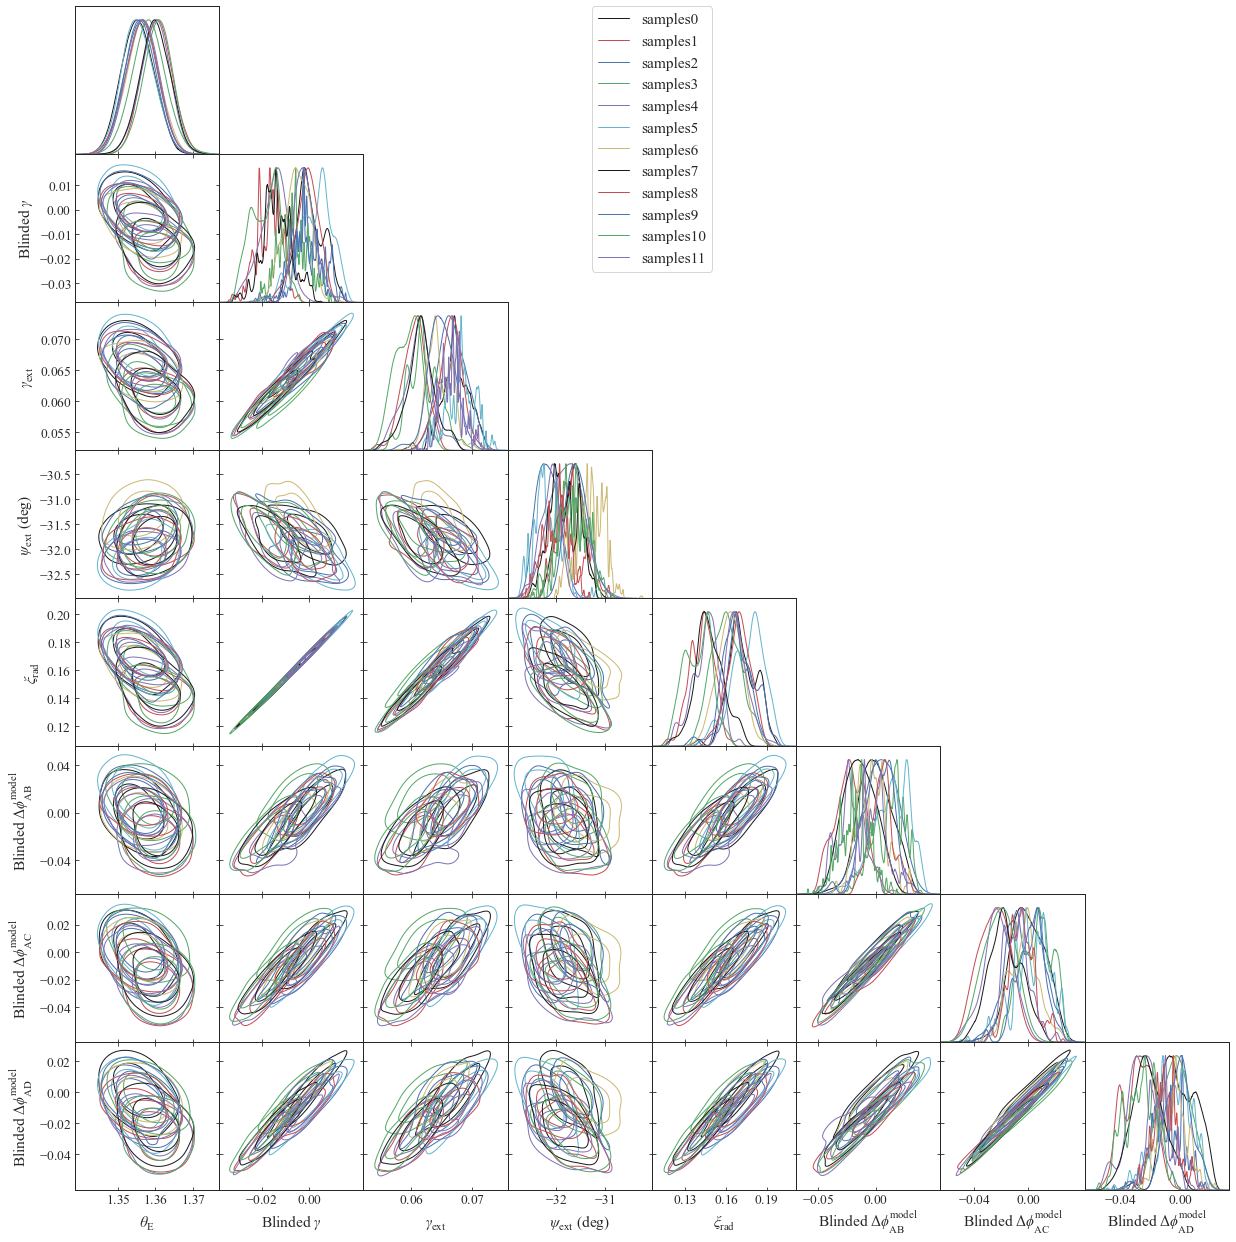

In [21]:
%matplotlib inline

pl_samples_list = []

for k in range(12):
    pl_samples = np.array([powerlaw_theta_es[k],
                           powerlaw_gammas[k],
                           powerlaw_gamma_exts[k],
                           powerlaw_psi_exts[k],
                           powerlaw_invariant_gradients[k],
                           powerlaw_dphi_ABs[k],
                           powerlaw_dphi_ACs[k],
                           powerlaw_dphi_ADs[k],
                           #powerlaw_Ds_Ddss[k][np.random.randint(0, high=len(powerlaw_Ds_Ddss[k]), size=len(powerlaw_theta_es[k]))]
                          ])
    if k == 0:
        gamma = np.mean(pl_samples[1])
        mean_dphi_AB = np.mean(pl_samples[5])
        mean_dphi_AC = np.mean(pl_samples[6])
        mean_dphi_AD = np.mean(pl_samples[7])
        #mean_DsDds = np.mean(pl_samples[7])

    pl_samples[1] = pl_samples[1]/gamma - 1.
    pl_samples[5]  = pl_samples[5]/mean_dphi_AB - 1.
    pl_samples[6]  = pl_samples[6]/mean_dphi_AC - 1.
    pl_samples[7]  = pl_samples[7]/mean_dphi_AD - 1.
    #pl_samples[7]  = pl_samples[7]/mean_DsDds - 1.

    print('Chain shape:', np.array(pl_samples).shape)#, np.array(comp_samples).shape)
    
    pl_samples_list.append(MCSamples(samples=np.array(pl_samples).T, 
                          names=['theta_E', 
                                 'gamma', 'gamma_ext', 'psi_ext', 'invariant_grad',
                                 'dphi_AB', 'dphi_AC', 'dphi_AD', #'DsDds'
                                ], 
                          labels=['{\\theta}_{\\rm{E}}', 
                                  '{\\rm Blinded}\\ \\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                  '\\gamma_{\\rm{ext}}', 
                                  '\\psi_{\\rm{ext}} {\\rm\ (deg)}',
                                  '\\xi_{\\rm rad}',
                                  '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                  '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                  '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                  #'{\\rm blinded}\\ D_{\\rm s}/D_{\\rm ds}'
                                 ],
                      ))
    pl_samples_list[-1].updateSettings({'smooth_scale_2D': 0.7})
    
    
pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 18
g.settings.legend_fontsize = 18

g.triangle_plot(pl_samples_list,
                contour_lws=[1.]*12, 
                contour_ls=['-']*12, #+ ['--']*12,
               )

#g.fig.tight_layout()

### plot comparisons between all composite models

Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in
Chain shape: (8, 1000)
Removed no burn in


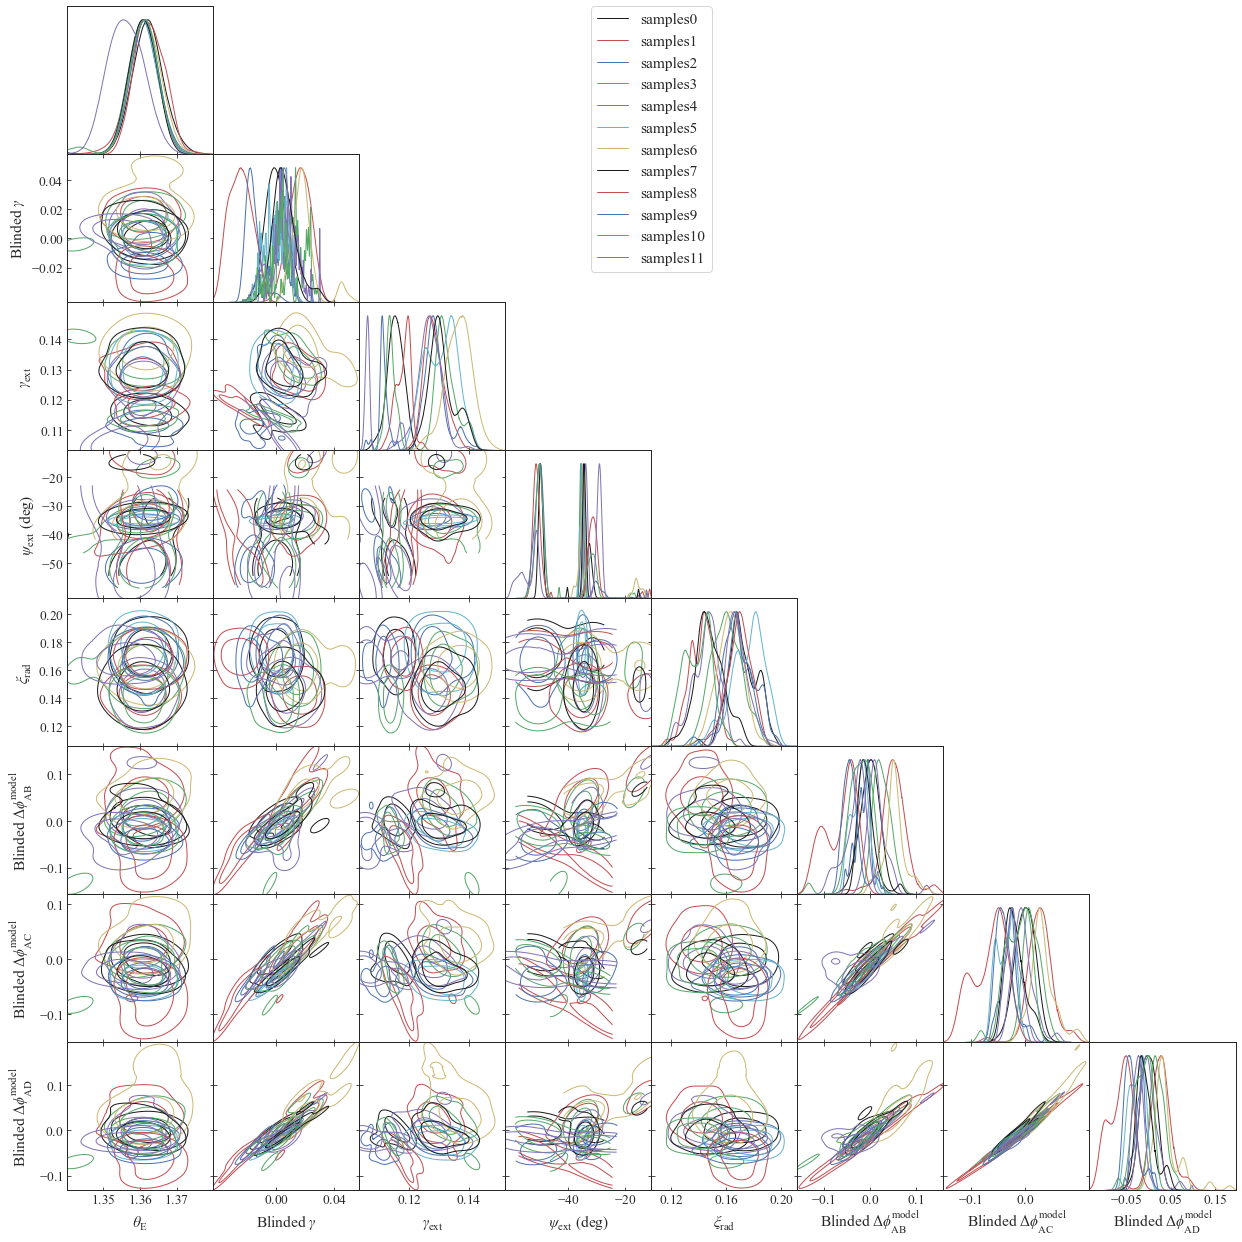

In [22]:
%matplotlib inline

composite_samples_list = []
    
for k in range(len(composite_files)):
    composite_samples = np.array([composite_theta_es[k], 
                                  composite_gammas[k],
                                  composite_gamma_exts[k],
                                  composite_psi_exts[k],
                                  powerlaw_invariant_gradients[k],
                                  composite_dphi_ABs[k],
                                  composite_dphi_ACs[k],
                                  composite_dphi_ADs[k],
                                  #composite_Ds_Ddss[k][np.random.randint(0, high=len(composite_Ds_Ddss[k]), size=len(composite_theta_es[k]))]
                               ])
    if k == 0:
        mean_gamma = np.mean(composite_samples[1])
        mean_dphi_AB = np.mean(composite_samples[5])
        mean_dphi_AC = np.mean(composite_samples[6])
        mean_dphi_AD = np.mean(composite_samples[7])
        #mean_DsDds = np.mean(composite_samples[7])

    composite_samples[1] = composite_samples[1]/mean_gamma - 1.
    composite_samples[5]  = composite_samples[5]/mean_dphi_AB - 1.
    composite_samples[6]  = composite_samples[6]/mean_dphi_AC - 1.
    composite_samples[7]  = composite_samples[7]/mean_dphi_AD - 1.
    #composite_samples[7]  = composite_samples[7]/mean_DsDds - 1.

    print("Chain shape:", np.array(composite_samples).shape)#, np.array(comp_samples).shape)
    
    if len(np.array(composite_samples).shape) < 2:
        continue
        
    composite_samples_list.append(MCSamples(samples=composite_samples.T, 
                          names=['theta_E', 
                                 'gamma', 'gamma_ext', 'psi_ext', 'invariant_grad',
                                 'dphi_AB', 'dphi_AC', 'dphi_AD', #'DsDds'
                                ], 
                          labels=['{\\theta}_{\\rm{E}}', 
                                  '{\\rm Blinded}\\ \\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                  '\\gamma_{\\rm{ext}}', 
                                  '\\psi_{\\rm{ext}} {\\rm\ (deg)}',
                                  '\\xi_{\\rm rad}',
                                  '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                  '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                  '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                  #'{\\rm blinded}\\ D_{\\rm s}/D_{\\rm ds}'
                                 ],
                      ))
    composite_samples_list[-1].updateSettings({'smooth_scale_2D': 0.7})
    
plt.show()

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 16
g.settings.lab_fontsize = 18
g.settings.legend_fontsize = 18

g.triangle_plot(composite_samples_list,
                contour_lws=[1.]*24, 
                contour_ls=['-']*12 + ['--']*12,
                param_limits={'theta_E': (1.34, 1.38)},
               )

#g.fig.tight_layout()

## BIC weighting

Compute variance of BIC between pairs.

In [23]:
def mad(x):
    med = np.median(x)    
    return np.median(np.abs(x - med))

sigma_numeric_bic = 1.48 * mad(np.append(np.abs(np.array(powerlaw_bics)[:6] - np.array(powerlaw_bics)[6:]),
                 np.abs(np.array(composite_bics)[:6] - np.array(composite_bics)[6:])
                )
      )


neighbor_indices = [
    [1, 2], [2, 3],
    [4, 5], [5, 6],
    [1, 4], [2, 5], [3, 6],
    
    [7, 8], [8, 9],
    [10, 11], [11, 12],
    [7, 10], [8, 11], [9, 12],
    
    [1, 8], [8, 3],
    [7, 2], [2, 9],
    
    [4, 11], [11, 6],
    [10, 5], [5, 12],
]

d_bic_neighbors = []
for ni in neighbor_indices:
    d_bic_neighbors.append(abs(powerlaw_bics[ni[0] - 1] - powerlaw_bics[ni[1] - 1]))
    if 12 not in ni:
        d_bic_neighbors.append(abs(composite_bics[ni[0] - 1] - composite_bics[ni[1] - 1]))
        

sigma_model_bic = 1.48 * mad(d_bic_neighbors)

sigma_numeric_bic, sigma_model_bic

(99.91711718678918, 325.16992966107614)

In [24]:
#sigma_numeric_bic, sigma_model_bic = 69.05339424569138, 237.25336211795366

## Make Table for paper

In [25]:
n_max = [r'$\{7, 11\}$',  r'$\{8, 12\}$', r'$\{9, 13\}$']
mask_size = [r'$\{ 2.2,3.6 \}$', r'$\{ 2.3,3.7 \}$']

def make_bic_table(bics, model):
    """
    """
    min_bic = np.min(bics)
    del_bic = bics - min_bic

    ordered_indices = np.argsort(bics)

    weights = get_relative_weights(bics, sigma_numeric_bic, take_std=False, sigma_model=sigma_model_bic)
    
    if model == 'Composite':
        files = composite_files
        run_ids = np.array([205, 206]) #([178, 179])
    elif model == 'Power law':
        files = powerlaw_files
        run_ids = np.array([145, 146])
        
    for i in (ordered_indices):
        run_no = np.argwhere(run_ids == int(files[i][8:11])).squeeze()
        n_max_no = int(files[i][16:17])
        mask_no = int(files[i][14:15])
        print('{} & {} & {} & {} & {} & {} & {:.2f} \\\\'.format(model, n_max[n_max_no], 
                                                               mask_size[mask_no], run_no+1, 
                                                               int(bics[i]), 
                                                               int(del_bic[i]), weights[i]))
        #print(n_max_no, composite_bics[i], del_bic[i], mask_no, weights[i])
    

    
make_bic_table(powerlaw_bics, 'Power law')
make_bic_table(composite_bics, 'Composite')

Power law & $\{9, 13\}$ & $\{ 2.2,3.6 \}$ & 2 & 26711 & 0 & 1.00 \\
Power law & $\{9, 13\}$ & $\{ 2.2,3.6 \}$ & 1 & 26755 & 43 & 0.95 \\
Power law & $\{8, 12\}$ & $\{ 2.2,3.6 \}$ & 2 & 26921 & 209 & 0.76 \\
Power law & $\{8, 12\}$ & $\{ 2.2,3.6 \}$ & 1 & 26947 & 235 & 0.73 \\
Power law & $\{7, 11\}$ & $\{ 2.2,3.6 \}$ & 2 & 27318 & 606 & 0.37 \\
Power law & $\{7, 11\}$ & $\{ 2.2,3.6 \}$ & 1 & 27438 & 726 & 0.29 \\
Power law & $\{9, 13\}$ & $\{ 2.3,3.7 \}$ & 2 & 28841 & 2129 & 0.00 \\
Power law & $\{8, 12\}$ & $\{ 2.3,3.7 \}$ & 2 & 29062 & 2350 & 0.00 \\
Power law & $\{9, 13\}$ & $\{ 2.3,3.7 \}$ & 1 & 29078 & 2366 & 0.00 \\
Power law & $\{7, 11\}$ & $\{ 2.3,3.7 \}$ & 2 & 29490 & 2778 & 0.00 \\
Power law & $\{8, 12\}$ & $\{ 2.3,3.7 \}$ & 1 & 29498 & 2786 & 0.00 \\
Power law & $\{7, 11\}$ & $\{ 2.3,3.7 \}$ & 1 & 29505 & 2793 & 0.00 \\
Composite & $\{9, 13\}$ & $\{ 2.2,3.6 \}$ & 1 & 26660 & 0 & 1.00 \\
Composite & $\{9, 13\}$ & $\{ 2.2,3.6 \}$ & 2 & 26671 & 10 & 0.99 \\
Composite & $\{8, 12

## Plot power-law vs composite comparison

(285,) (285,) (10, 285)
(729,) (729,) (10, 729)
(949,) (949,) (10, 949)
(0,) (0,) (10, 0)
(0,) (0,) (10, 0)
(0,) (0,) (10, 0)
(374,) (374,) (10, 374)
(758,) (758,) (10, 758)
(1000,) (1000,) (10, 1000)
(0,) (0,) (10, 0)
(0,) (0,) (10, 0)
(1,) (1,) (10, 1)
Power-law smaples: 4096
Removed no burn in
Composite smaples: 3835
Removed no burn in


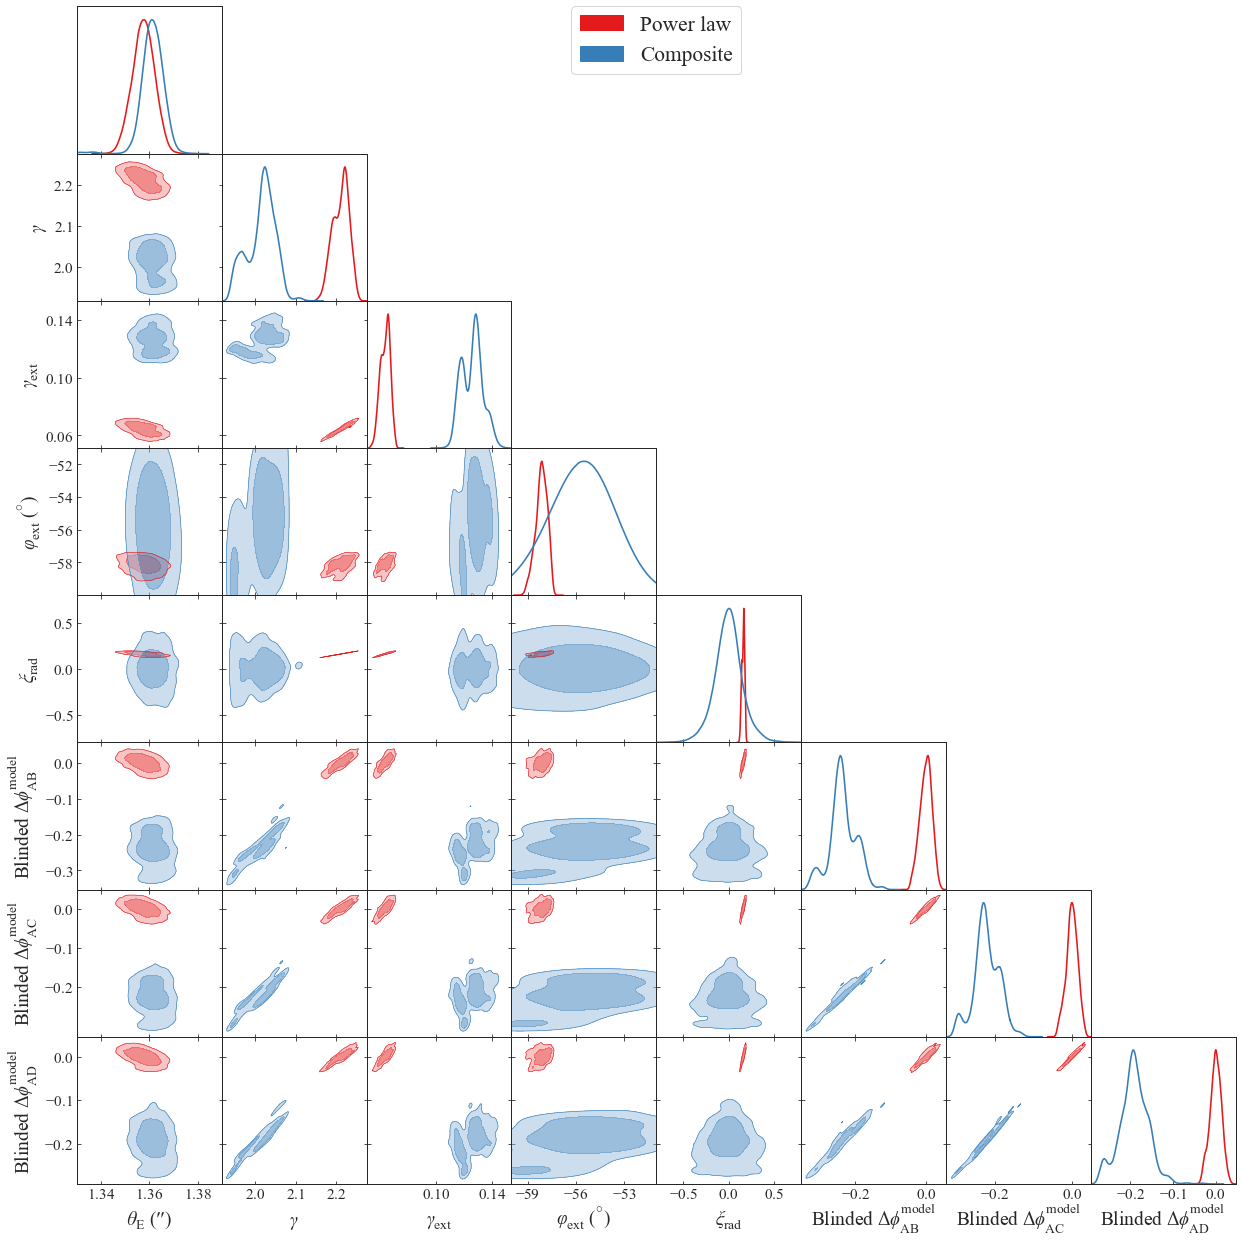

In [35]:
%matplotlib inline

smoothing_scale = 0.3

## join powerlaw model samples
pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)
all_pl_samples = np.array([])

for k in range(12):
    num_sample = int(pl_weights[k] * len(powerlaw_theta_es[k]))

    pl_samples = np.array([powerlaw_theta_es[k][:num_sample], 
                           powerlaw_gammas[k][:num_sample],
                           powerlaw_gamma_exts[k][:num_sample],
                           -np.array(powerlaw_psi_exts[k][:num_sample]) - 90,
                           powerlaw_invariant_gradients[k][:num_sample],
                           powerlaw_dphi_ABs[k][:num_sample],
                           powerlaw_dphi_ACs[k][:num_sample],
                           powerlaw_dphi_ADs[k][:num_sample],
                           list(powerlaw_qs[k][:num_sample]),
                           list(powerlaw_pas[k][:num_sample]) 
                        ])
    print(np.array(powerlaw_pas[k][:num_sample]).shape, np.array(powerlaw_qs[k][:num_sample]).shape, pl_samples.shape)
    if k == 0:
        all_pl_samples = pl_samples
    else:
        all_pl_samples = np.append(all_pl_samples, pl_samples, axis=1)
    

mean_gamma = np.mean(all_pl_samples[1])
mean_dphi_AB = np.mean(all_pl_samples[4+1])
mean_dphi_AC = np.mean(all_pl_samples[5+1])
mean_dphi_AD = np.mean(all_pl_samples[6+1])

# blinding some parameters
#all_pl_samples[1] = all_pl_samples[1]/mean_gamma - 1.
all_pl_samples[4+1] = all_pl_samples[5]/mean_dphi_AB - 1.
all_pl_samples[5+1] = all_pl_samples[6]/mean_dphi_AC - 1.
all_pl_samples[6+1] = all_pl_samples[7]/mean_dphi_AD - 1.


print('Power-law smaples: {}'.format(all_pl_samples.shape[1]))


powerlaw_mc_samples= MCSamples(samples=all_pl_samples[:-2].T, 
                               names=['theta_E', 
                                      'gamma', 'gamma_ext', 'psi_ext', 'invariant_grad',
                                      'dphi_AB', 'dphi_AC', 'dphi_AD'
                                     ], 
                              labels=['{\\theta}_{\\rm{E}}\ ({\prime\prime})', 
                                      '\\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                      '\\gamma_{\\rm{ext}}', 
                                      '\\varphi_{\\rm{ext}} {\ (^{\circ})}', 
                                      '\\xi_{\\rm rad}',
                                      '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                      '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                      '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                     ],
                  )
powerlaw_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
powerlaw_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})
    

## join composite model samples
composite_weights = get_relative_weights(composite_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)
all_composite_samples = np.array([])

for k in range(len(composite_files)):
    num_sample = int(composite_weights[k] * len(composite_theta_es[k]))
    
    composite_samples = np.array([composite_theta_es[k][:num_sample], 
                            composite_gammas[k][:num_sample],
                            composite_gamma_exts[k][:num_sample],
                            -np.array(composite_psi_exts[k][:num_sample]) - 90,
                            composite_invariant_gradients[k][:num_sample],
                            composite_dphi_ABs[k][:num_sample],
                            composite_dphi_ACs[k][:num_sample],
                            composite_dphi_ADs[k][:num_sample],
                           ])
    if k == 0:
        all_composite_samples = composite_samples
    else:
        all_composite_samples = np.append(all_composite_samples, composite_samples, axis=1)
        

#all_composite_samples[1] = all_composite_samples[1]/mean_gamma - 1.
all_composite_samples[4+1] = all_composite_samples[4+1]/mean_dphi_AB - 1.
all_composite_samples[5+1] = all_composite_samples[5+1]/mean_dphi_AC - 1.
all_composite_samples[6+1] = all_composite_samples[6+1]/mean_dphi_AD - 1.

print('Composite smaples: {}'.format(all_composite_samples.shape[1]))
    
composite_mc_samples = MCSamples(samples=all_composite_samples.T, 
                                 names=['theta_E', 
                                        'gamma', 'gamma_ext', 'psi_ext',  'invariant_grad', #'theta_E_sat', 'theta_E_G3', 
                                        'dphi_AB', 'dphi_AC', 'dphi_AD', 
                                       ], 
                                 labels=['{\\theta}_{\\rm{E}}\ ({\prime\prime})', 
                                         '\\gamma', #'{\\gamma}/\\overline{{\\gamma}} - 1',
                                         '\\gamma_{\\rm{ext}}', 
                                         '\\varphi_{\\rm{ext}} {\ (^{\circ})}', 
                                         '\\xi_{\\rm rad}',
                                         '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AB}', #'\\Delta \\phi^{\\rm eff}_{\\rm AB} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AB}} - 1',
                                         '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AC}', #'\\Delta \\phi^{\\rm eff}_{\\rm AC} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AC}} - 1',
                                         '{\\rm Blinded}\\ \\Delta \\phi^{\\rm model}_{\\rm AD}', #'\\Delta \\phi^{\\rm eff}_{\\rm AD} / \\overline{\\Delta \\phi^{\\rm eff}_{\\rm AD}} - 1',
                                        ],
                  )
composite_mc_samples.updateSettings({'smooth_scale_2D': smoothing_scale})
composite_mc_samples.updateSettings({'smooth_scale_1D': smoothing_scale})
    

pf.set_fontscale(2.)

g = plots.getSubplotPlotter(subplot_size=2.2)
g.settings.lw_contour = 1.
g.settings.alpha_factor_contour_lines = 2.
g.settings.solid_contour_palefactor = 0.5
g.settings.axes_fontsize = 18
g.settings.lab_fontsize = 22

g.settings.legend_fontsize = 24

colors = [pf.cb_red, pf.cb_blue]

g.triangle_plot([powerlaw_mc_samples, composite_mc_samples],
                 legend_labels=['Power law', 'Composite'],
                 filled=True, shaded=False,
                 alpha_filled_add=.5, 
                 contour_lws=[1.6, 1.6], 
                 contour_ls=['-', '-'],
                 #filled=False,
                 #contour_colors=[sns.xkcd_rgb['emerald'], sns.xkcd_rgb['bright orange']], 
                 contour_args={'alpha': .5},
                 #line_args={'lw': 7., "zorder": 30},
                 #line_args={'lw': 1., 'alpha': 1.}
                 contour_colors=colors,
                 param_limits={'theta_E': (1.33, 1.39), 'psi_ext': (-60, -51), 
                               'invariant_grad': (-0.8, 0.8)
                              },
                 #fontsize=100
               )

#g.fig.tight_layout()
if savefig:
    g.fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/mass_model_compare_pl_composite.pdf', bbox_inches='tight')

In [88]:
## join powerlaw model samples
pl_weights = get_relative_weights(powerlaw_bics, sigma_numeric_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)
all_pl_samples_elliptical = np.array([])

for k in range(12):
    num_sample = int(pl_weights[k] * len(powerlaw_theta_es[k]))

    pl_samples_elliptical = np.array([powerlaw_theta_es_elliptical[k][:num_sample], 
                           powerlaw_gammas_elliptical[k][:num_sample],
                           powerlaw_gamma_exts[k][:num_sample],
                           powerlaw_psi_exts[k][:num_sample],
                           powerlaw_invariant_gradients_ellipticals[k][:num_sample],
                           powerlaw_dphi_ABs[k][:num_sample],
                           powerlaw_dphi_ACs[k][:num_sample],
                           powerlaw_dphi_ADs[k][:num_sample],
                           list(powerlaw_qs[k][:num_sample]),
                           list(powerlaw_pas[k][:num_sample]) 
                        ])
    print(np.array(powerlaw_pas[k][:num_sample]).shape, np.array(powerlaw_qs[k][:num_sample]).shape, pl_samples_elliptical.shape)
    if k == 0:
        all_pl_samples_elliptical = pl_samples_elliptical
    else:
        all_pl_samples_elliptical = np.append(all_pl_samples_elliptical, pl_samples_elliptical,
                                              axis=1)

(285,) (285,) (10, 285)
(729,) (729,) (10, 729)
(948,) (948,) (10, 948)
(0,) (0,) (10, 0)
(0,) (0,) (10, 0)
(0,) (0,) (10, 0)
(371,) (371,) (10, 371)
(757,) (757,) (10, 757)
(1000,) (1000,) (10, 1000)
(0,) (0,) (10, 0)
(0,) (0,) (10, 0)
(1,) (1,) (10, 1)


In [89]:
np.savetxt('../model_posteriors/lenstronomy_all_pl_params.txt', all_pl_samples_elliptical)
#np.savetxt('../lenstronomy_outputs/all_comp_params.txt', all_composite_samples)

In [40]:
mean_gamma, mean_dphi_AB, mean_dphi_AC, mean_dphi_AD

(2.212054295848871,
 -0.12955683392214323,
 -0.25935528535071195,
 -0.6287648176430323)

In [25]:
# pl gamma
gamma_low, gamma_med, gamma_hi = np.percentile(all_pl_samples[1] + mean_gamma, #all_composite_samples[1]), 
                                               q=[16, 50, 84]
                                               )

print('PL gamma = {:.2f}-{:.2f}+{:.2f}'.format(
                    gamma_med, gamma_med-gamma_low, gamma_hi-gamma_med))

PL gamma = 2.21-0.01+0.01


In [26]:
# combined theta_E
theta_E_low, theta_E_med, theta_E_hi = np.percentile(np.append(all_pl_samples[0], all_composite_samples[0]), 
                                                     q=[16, 50, 84]
                                                    )

print('Einstein radius = {:.2f}-{:.2f}+{:.2f}'.format(
                    theta_E_med, theta_E_med-theta_E_low, theta_E_hi-theta_E_med))

Einstein radius = 1.36-0.00+0.00


In [27]:
# shear parameters for external convergence estimate

shear_mag_low, shear_mag_med, shear_mag_hi = np.percentile(all_pl_samples[2], q=[16, 50, 84])
shear_ang_low, shear_ang_med, shear_ang_hi = np.percentile(all_pl_samples[3], q=[16, 50, 84])
print('Power law ==> shear mag: {:.3f}-{:.3f}+{:.3f}, shear angle: {:.1f}-{:.1f}+{:.1f} deg'.format(
    shear_mag_med, shear_mag_med - shear_mag_low, shear_mag_hi - shear_mag_med,
    shear_ang_med, shear_ang_med - shear_ang_low, shear_ang_hi - shear_ang_med,
))

shear_mag_low, shear_mag_med, shear_mag_hi = np.percentile(all_composite_samples[2], q=[16, 50, 84])
shear_ang_low, shear_ang_med, shear_ang_hi = np.percentile(all_composite_samples[3], q=[16, 50, 84])
print('Composite ==> shear mag: {:.2f}-{:.2f}+{:.2f}, shear angle: {:.1f}-{:.1f}+{:.1f} deg'.format(
    shear_mag_med, shear_mag_med - shear_mag_low, shear_mag_hi - shear_mag_med,
    shear_ang_med, shear_ang_med - shear_ang_low, shear_ang_hi - shear_ang_med,
))


Power law ==> shear mag: 0.065-0.004+0.003, shear angle: -31.9-0.4+0.4 deg
Composite ==> shear mag: 0.13-0.01+0.01, shear angle: -34.6-16.1+1.3 deg


In [28]:
# deviation in percent in compostie Fermat potential differences
for i in [5, 6, 7]:
    print(np.median(all_composite_samples[i]))

-0.20948649451724344
-0.19702896493222755
-0.16950812460354758


## Plot intra-model comparisons

In [29]:
from scipy.stats import gaussian_kde

In [30]:
def compare_settings(sets, axes, model='Power law', labels=[], ls=None, verbose=False):
    """
    Plot comparisons between models
    :param sets: list of lists containing sets of model runs
    :param model: 'Power law' or 'composite'
    """ 
    maxs, mins = [], []
    
    all_samples_list = []
    
    if ls is None:
        ls = ['-'] * len(sets)
        
    for n, _set in enumerate(sets):
        if model == 'Power law':
            bics = np.array(powerlaw_bics)[_set]
        elif model == 'Composite previous':
            bics = np.array(composite_bics_prev)[_set]
        else:
            bics = np.array(composite_bics)[_set]

        
        weights = get_relative_weights(bics, sigma_numeric_bic, take_std=False, sigma_model=sigma_model_bic)
        #print(bics, weights)
        samples_list = [[], [], []]

        for j, k in enumerate(_set):
            indices = np.random.randint(low=0, high=N_sample, size=int(weights[j]*N_sample))
            #print(indices, weights[i])
            
            if len(indices) == 0:
                continue
                
            if model == 'Power law':
                samples_list[0] += [powerlaw_dphi_ABs[k][i] for i in indices]
                samples_list[1] += [powerlaw_dphi_ACs[k][i] for i in indices]
                samples_list[2] += [powerlaw_dphi_ADs[k][i] for i in indices]
            elif model == 'Composite priors':
                if n == 1:
                    samples_list[0] += [composite_dphi_ABs_prev[k][i] for i in indices]
                    samples_list[1] += [composite_dphi_ACs_prev[k][i] for i in indices]
                    samples_list[2] += [composite_dphi_ADs_prev[k][i] for i in indices]
                else:
                    samples_list[0] += [composite_dphi_ABs[k][i] for i in indices]
                    samples_list[1] += [composite_dphi_ACs[k][i] for i in indices]
                    samples_list[2] += [composite_dphi_ADs[k][i] for i in indices]
            else:
                samples_list[0] += [composite_dphi_ABs[k][i] for i in indices]
                samples_list[1] += [composite_dphi_ACs[k][i] for i in indices]
                samples_list[2] += [composite_dphi_ADs[k][i] for i in indices]
         
        samples_list = np.array(samples_list)
        
        if  n == 0:
            mean_dphi_AB = np.mean(samples_list[0])
            mean_dphi_AC = np.mean(samples_list[1])
            mean_dphi_AD = np.mean(samples_list[2])
        
        samples_list[0] = samples_list[0]/mean_dphi_AB - 1
        samples_list[1] = samples_list[1]/mean_dphi_AC - 1
        samples_list[2] = samples_list[2]/mean_dphi_AD - 1
        
        if n != 0:
            print(n)
            print(np.median(samples_list[0]))
            print(np.median(samples_list[1]))
            print(np.median(samples_list[2]))
        
        maxs.append(np.percentile(samples_list, q=[99], axis=1))
        mins.append(np.percentile(samples_list, q=[1], axis=1))
        
        all_samples_list.append(samples_list)
        
    extents = [[a, b] for a, b in zip(np.min(mins, axis=0).squeeze(), np.max(maxs, axis=0).squeeze())]
    
    for n in range(len(sets)):
        for i in range(3):
            samples = all_samples_list[n][i]
            xs = np.linspace(extents[i][0]-0.02, extents[i][1]+0.02, 100)
            kde = gaussian_kde(samples)
            
            low, hi = np.percentile(samples, q=[16, 84])
            one_sig_xs = np.linspace(low, hi, 100)
            
            axes[i].plot(xs, kde(xs), c=colors[n], lw=2, label=labels[n], ls=ls[n])
            axes[i].fill_between(one_sig_xs, kde(one_sig_xs), alpha=0.3, color=colors[n])
            axes[i].set_xlim(extents[i][0]-0.02, extents[i][1]+0.02)
            
            if n == len(sets) - 1:
                axes[i].set_ylim(bottom=0.)
            
            axes[i].set_yticks([])
            
    axes[0].text(0.05, 0.9, 'Power law' if model=='Power law' else 'Composite', transform=axes[0].transAxes)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[3].legend(handles, labels, loc='center left')
    axes[3].axis('off')


1
-0.017110396335091482
-0.01926173028248651
-0.022193775044947184
2
0.007918742908090914
-0.0017212990441622944
-0.006127810189977212
1
0.002389576728342724
0.0015887799693652394
0.0006949836112908336
1
0.01505214752343198
-0.00441257064613626
-0.006224852908852885
2
-0.04714343805095844
-0.054081467296629104
-0.04897544224124739
1
-0.003295257673106511
-0.0010452595457097758
-0.001190940655204642


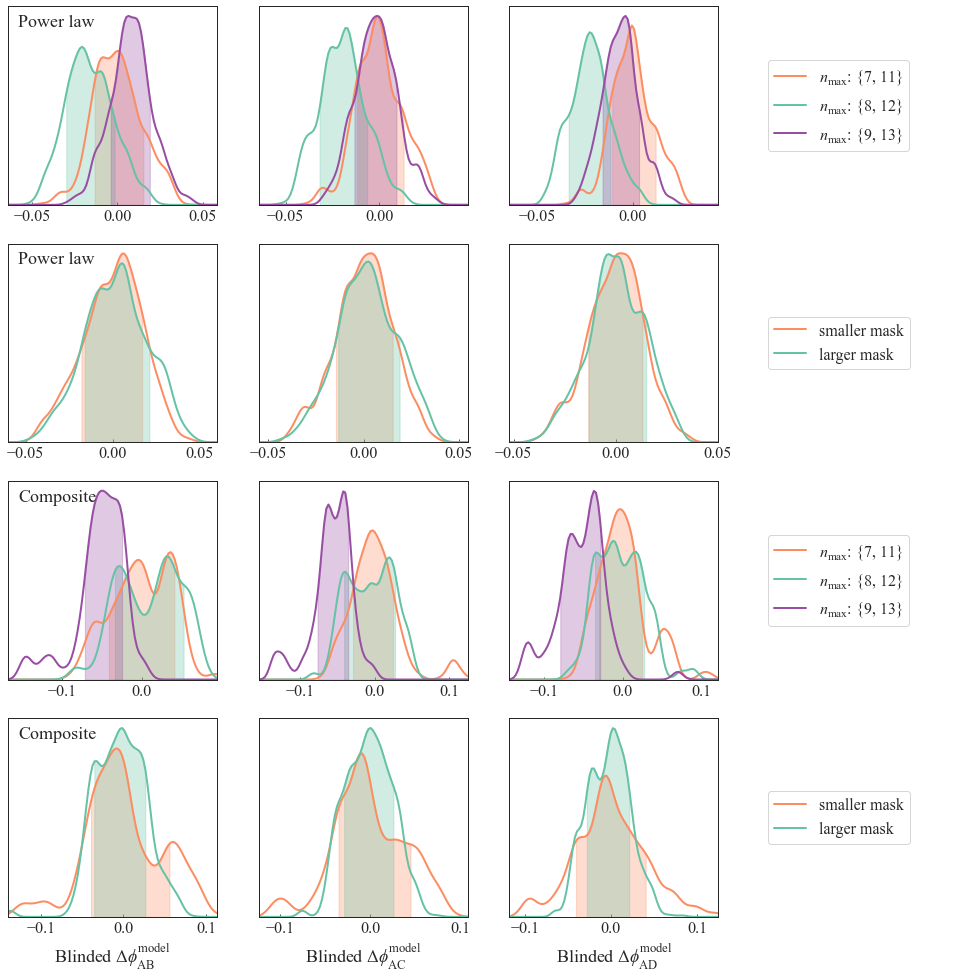

In [31]:
pf.set_fontscale(2.)
colors = [pf.cb2_orange, pf.cb2_emerald, pf.cb_purple]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=pf.get_fig_size(pf.mnras_textwidth*2, height_ratio=1));

compare_settings([[0, 3, 6, 9], [1, 4, 7, 10], [2, 5, 8, 11]], axes[0], 
                 labels=[r'$n_{\rm max}$: {7, 11}', r'$n_{\rm max}$: {8, 12}', r'$n_{\rm max}$: {9, 13}'])

compare_settings([[0, 1, 2, 6, 7, 8], [3, 4, 5, 9, 10, 11]], axes[1], 
                 labels=[r'smaller mask', r'larger mask'])

compare_settings([[0, 3, 6, 9], [1, 4, 7, 10], [2, 5, 8]], axes[2], model='Composite',
                 labels=[r'$n_{\rm max}$: {7, 11}', r'$n_{\rm max}$: {8, 12}', r'$n_{\rm max}$: {9, 13}'])

compare_settings([[0, 1, 2, 6, 7, 8], [3, 4, 5, 9, 10]], axes[3], model='Composite', 
                 labels=[r'smaller mask', r'larger mask'])

axes[3, 0].set_xlabel(r'Blinded $\Delta \phi^{\rm model}_{\rm AB}$')#(r'$\Delta \phi^{\rm model}_{\rm AB} / \overline{\Delta \phi^{\rm model}_{\rm AB}} - 1$')
axes[3, 1].set_xlabel(r'Blinded $\Delta \phi^{\rm model}_{\rm AC}$')#(r'$\Delta \phi^{\rm model}_{\rm AC} / \overline{\Delta \phi^{\rm model}_{\rm AC}} - 1$')
axes[3, 2].set_xlabel(r'Blinded $\Delta \phi^{\rm model}_{\rm AD}$')#(r'$\Delta \phi^{\rm model}_{\rm AD} / \overline{\Delta \phi^{\rm model}_{\rm AD}} - 1$')

fig.tight_layout()

if savefig:
    plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/mass_model_compare.pdf', bbox_inches='tight')

## load composite models with test prior

The code below loads another set of composite models that differs in various settings: unfixed triple Chameleon light profiles, no central mask, and a different prior for the NFW profile (Gaussian on $r_{\rm s}$ based on Gavazzi et al. 2007).

In [32]:
composite_files_prev = [
    '2038_run215_1_0_0_0_0_shortened',
    '2038_run215_1_0_1_0_0_shortened',
    '2038_run215_1_0_2_0_0_shortened',
    '2038_run215_1_1_0_0_0_shortened',
    '2038_run215_1_1_1_0_0_shortened',
    '2038_run215_1_1_2_0_0_shortened',
    
    '2038_run214_1_0_0_0_0_shortened',
    '2038_run214_1_0_1_0_0_shortened',
    '2038_run214_1_0_2_0_0_shortened',
    '2038_run214_1_1_0_0_0_shortened',
    '2038_run214_1_1_1_0_0_shortened',
    '2038_run214_1_1_2_0_0_shortened',
#     '2038_run178_1_0_0_0_0_shortened',
#     '2038_run178_1_0_1_0_0_shortened',
#     '2038_run178_1_0_2_0_0_shortened',
#     '2038_run178_1_1_0_0_0_shortened',
#     '2038_run178_1_1_1_0_0_shortened',
#     '2038_run178_1_1_2_0_0_shortened',
    
#     '2038_run179_1_0_0_0_0_shortened',
#     '2038_run179_1_0_1_0_0_shortened',
#     '2038_run179_1_0_2_0_0_shortened',
#     '2038_run179_1_1_0_0_0_shortened',
#     '2038_run179_1_1_1_0_0_shortened',
#     '2038_run179_1_1_2_0_0_shortened',
]

def custom_loglikelihood_addition(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None):
    """
    """
    if kwargs_lens[0]['alpha_Rs'] < 0.:
        return -np.inf
    
    if not -0.014271818911080656-0.2 < kwargs_lens[0]['center_x'] < -0.014271818911080656+0.2:
        return -np.inf
    if not -0.020882886550870693-0.2 < kwargs_lens[0]['center_y'] < -0.020882886550870693+0.2:
        return -np.inf
    
    if not -0.5 < kwargs_lens[0]['e1'] < 0.5:
        return -np.inf
    if not -0.5 < kwargs_lens[0]['e2'] < 0.5:
        return -np.inf
    
    #kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': r_s_prior_mu-5*r_s_prior_sigma, 'center_x': lens_center_ra-0.2, 'center_y': lens_center_dec-0.2, 'e1': -0.5, 'e2': -0.5})
    #kwargs_upper_lens.append({'alpha_Rs': 10, 'Rs': r_s_prior_mu+5*r_s_prior_sigma, 'center_x': lens_center_ra+0.2, 'center_y': lens_center_dec+0.2, 'e1': 0.5, 'e2': 0.5})
        
    return 0.

In [33]:
composite_bics_prev = []
composite_param_arrays_prev = []
composite_num_param_arrays_prev = []
composite_kwargs_models_prev = []
composite_kwargs_constraints_prev = []
composite_param_classes_prev = []
composite_lens_models_prev = []
composite_kwargs_likelihoods_prev = []
composite_multi_band_list_prev = []

for job_name_out in composite_files_prev:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]

    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    composite_bics_prev.append(bic)
    composite_param_arrays_prev.append(np.copy(samples_mcmc))
    composite_num_param_arrays_prev.append(len(samples_mcmc))
    composite_kwargs_models_prev.append(kwargs_model)
    composite_kwargs_constraints_prev.append(kwargs_constraints)
    composite_param_classes_prev.append(param_class)
    composite_lens_models_prev.append(lens_model)
    composite_kwargs_likelihoods_prev.append(kwargs_likelihood)
    composite_multi_band_list_prev.append(multi_band_list_out)
    
    gc.collect()
    #break

In [34]:
composite_theta_es_prev = []
composite_gammas_prev = []

composite_gamma_exts_prev = []
composite_psi_exts_prev = []
composite_reffs_prev = []

composite_dphi_ABs_prev = []
composite_dphi_ACs_prev = []
composite_dphi_ADs_prev = []

composite_invariant_gradients_prev = []

composite_del_bics_prev = np.max(powerlaw_bics) - np.array(powerlaw_bics)
#composite_weights = get_relative_weights(powerlaw_bics, 0., take_std=False, sigma_model=np.std(composite_bics)) #np.exp(powerlaw_del_logZs) / np.sum(np.exp(powerlaw_del_logZs))
composite_weights_prev = [1.] * len(composite_lens_models_prev)

#print(composite_weights)

for n_job in tnrange(len(composite_files_prev), desc='Jobs:'):
    
    composite_theta_e = []
    composite_theta_e_precision = []
    composite_gamma = []
    composite_gamma_ext = []
    composite_psi_ext = []
    composite_reff = []

    composite_dphi_AB = []
    composite_dphi_AC = []
    composite_dphi_AD = []
    
    composite_invariant_gradient = []
    
    num_sample_from_job = int(composite_weights_prev[n_job] * N_sample) #composite_num_param_arrays[n_job])
    
    td_cosmography = TDCosmography(z_lens=0.230, z_source=0.777, kwargs_model=composite_kwargs_models_prev[n_job])
    
    lens_model = composite_lens_models_prev[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models_prev[n_job])
    param_class = composite_param_classes_prev[n_job]
    
    sampled_indices = []
    bad_indices = []
    
    while len(sampled_indices) < num_sample_from_job:
        if len(sampled_indices) + len(bad_indices) >= composite_num_param_arrays_prev[n_job]:
            print(len(sampled_indices), len(bad_indices))
            break
            
        try:
            sampled_index = np.random.randint(low=0, high=composite_num_param_arrays_prev[n_job])
            if sampled_index in sampled_indices or sampled_indices in bad_indices:
                continue

            #for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
            if True:
                param_array = composite_param_arrays_prev[n_job][sampled_index]
                #print(param_array)
                kwargs_result = param_class.args2kwargs(param_array)
                lens_result = kwargs_result['kwargs_lens']
                lens_light_result = kwargs_result['kwargs_lens_light']
                source_result = kwargs_result['kwargs_source']
                ps_result = kwargs_result['kwargs_ps']

                model_bool = [False] * len(lens_result)
                model_bool[0] = True
                model_bool[2] = True # True for composite
                model_index = [0, 2] #[0, 2] for composite
                
                theta_e, prec  = lens_analysis.effective_einstein_radius(lens_result, model_bool_list=model_index,
                                                                  grid_spacing=0.015, grid_num=200, 
                                                                  get_precision=True)
                #print(theta_e, prec)
                theta_e += np.random.normal(loc=0., scale=prec)
                #print(theta_e)
                #break
                composite_theta_e.append(theta_e)
                composite_gamma.append(lens_analysis.profile_slope(lens_result, theta_e))
                
                shear_psi, shear_mag = param_util.shear_cartesian2polar(lens_result[1]['gamma1'],
                                                                        lens_result[1]['gamma2'],
                                                                       )
                composite_gamma_ext.append(shear_mag)
                composite_psi_ext.append(shear_psi*180/np.pi)

                fermat_potential = td_cosmography.fermat_potential(lens_result, ps_result, original_ps_position=True)
                #print(model_arrival_times)
                #break

                dphi_AB = fermat_potential[1] - fermat_potential[3]
                dphi_AC = fermat_potential[1] - fermat_potential[2]
                dphi_AD = fermat_potential[1] - fermat_potential[0]

                composite_dphi_AB.append(dphi_AB)
                composite_dphi_AC.append(dphi_AC)
                composite_dphi_AD.append(dphi_AD)

                composite_invariant_gradient.append(lens_analysis.mst_invariant_differential(lens_result, theta_e))
                
                sampled_indices.append(sampled_index)

        except( ValueError, TypeError): 
            # there some samples that throws ValueError in the theta/gamma computation
            bad_indices.append(sampled_index)
        
    composite_theta_es_prev.append(np.nan_to_num(composite_theta_e, nan=np.nanmean(composite_theta_e)))
    composite_gammas_prev.append(composite_gamma)
    composite_dphi_ABs_prev.append(composite_dphi_AB)
    composite_dphi_ACs_prev.append(composite_dphi_AC)
    composite_dphi_ADs_prev.append(composite_dphi_AD)
    composite_gamma_exts_prev.append(composite_gamma_ext)
    composite_psi_exts_prev.append(composite_psi_ext)
    composite_invariant_gradients_prev.append(composite_invariant_gradient)

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


1
-0.07169875561399264
-0.04602789589608586
-0.04620489451300991


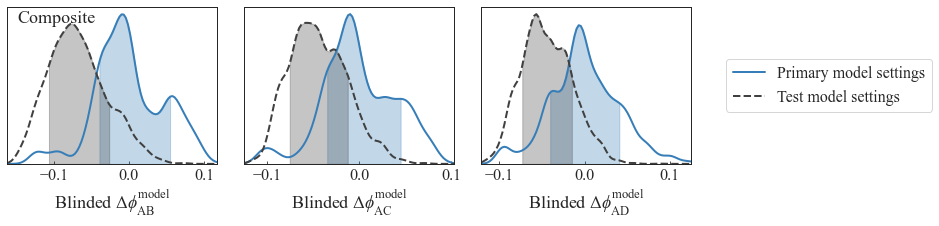

In [35]:
pf.set_fontscale(2.)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=pf.get_fig_size(pf.mnras_textwidth*2, height_ratio=1/4));

colors = [pf.cb_blue, pf.cb_grey]
compare_settings([np.arange(12), np.arange(12)], axes, labels=['Primary model settings', 'Test model settings'], 
                 ls=['-', '--'],
                 model='Composite priors', verbose=True)

# colors = [pf.cb_blue]
# compare_settings([np.arange(12)], axes, labels=['Prior 1'], model='Composite', ls='-')

axes[0].set_xlabel(r'Blinded $\Delta \phi^{\rm model}_{\rm AB}$')#(r'$\Delta \phi^{\rm model}_{\rm AB} / \overline{\Delta \phi^{\rm model}_{\rm AB}} - 1$')
axes[1].set_xlabel(r'Blinded $\Delta \phi^{\rm model}_{\rm AC}$')#(r'$\Delta \phi^{\rm model}_{\rm AC} / \overline{\Delta \phi^{\rm model}_{\rm AC}} - 1$')
axes[2].set_xlabel(r'Blinded $\Delta \phi^{\rm model}_{\rm AD}$')#(r'$\Delta \phi^{\rm model}_{\rm AD} / \overline{\Delta \phi^{\rm model}_{\rm AD}} - 1$')

fig.tight_layout()

if savefig:
    plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/lenstronomy_composite_priors_compare.pdf', bbox_inches='tight')
